# Final Project
by Malte Jörg

---
## 1. Bussiness Problem
- Compare Toronto's and New York's Nightlife
- Bars, Cafés and Restaurants

---
## 2. Data description
- get neighborhood data from the cities
- get venue data via foursquare

Python library imports:

In [4]:
import pandas as pd
import numpy as np
import geocoder
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

---
## 3. Data collection and preparation

...

### a) Location Data

New York dataset

In [5]:
# open new york dataset from downloaded json file
with open('data/newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [6]:
# only use data from features key
ny_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_ny = pd.DataFrame(columns=column_names)

# put relevant data from features into dataframe
for data in ny_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    df_ny = df_ny.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
print('Shape of Dataframe: ', df_ny.shape)
df_ny.head()

Shape of Dataframe:  (306, 4)


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Toronto dataset

In [7]:
# scraping table from wikipedia url
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_tor = pd.read_html(url)[0]

In [8]:
# drop not assigned boroughs and rename neighborhoods
df_tor = df_tor[~df_tor['Borough'].isin(['Not assigned'])].reset_index(drop=True)
for i in range(len(df_tor.index)):
    if df_tor['Neighborhood'].loc[i] == 'Not assigned':
       df_tor['Neighborhood'].loc[i] = df_tor['Borough'].loc[i]
    else:
        pass

In [9]:
# get geospatial coordinates from downloaded csv-file and assign to toronto dataframe
df_tor_geo = pd.read_csv('data/Geospatial_Coordinates.csv')
latitude = []
longitude = []
for postal_code in df_tor['Postal Code']:
    i = list(df_tor_geo['Postal Code']).index(postal_code)
    latitude.append(df_tor_geo['Latitude'].loc[i])
    longitude.append(df_tor_geo['Longitude'].loc[i])  
df_tor['Latitude'] = latitude
df_tor['Longitude'] = longitude

In [10]:
# drop postal code column to get consistent dataframe between new york and toronto
df_tor.drop(['Postal Code'], axis=1, inplace=True)

In [11]:
print('Shape of Dataframe: ', df_tor.shape)
df_tor.head()

Shape of Dataframe:  (103, 4)


,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### d) Venue data

In [12]:
# foursquare api details:
CLIENT_ID = '5EIRM5SCLCH5CVE5UT23UMXDRFT3MUDM3EZBVTGCW10WALKE'
CLIENT_SECRET = '0AMFGMH3OV3ILQRDA21AMHX23UIIMEZX0EPPLTHIKIWQJ51D'
VERSION = '20200601'
RADIUS = 500
LIMIT = 100

In [13]:
# function to get venues from foursquare by geographical coordinates
def getVenues(borough_names, neighborhood_names, latitudes, longitudes, RADIUS, LIMIT): 
    venues_list=[]

    for bname, nname, lat, lng in zip(borough_names, neighborhood_names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET,  
                lat, 
                lng,
                VERSION, 
                RADIUS, 
                LIMIT)
        req = {}
        print(nname)
        while req == {}:
            req = requests.get(url).json()["response"]  # foursquare request
        results = req['groups'][0]['items']
         
        venues_list.append([(
            bname,
            nname, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        

    venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    venues.columns = ['Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('done')    
    return(venues)

In [14]:
exec_fsq = False   # execute foursquare api venue exploration

In [15]:
# get new york venues
if exec_fsq == True:
    ny_venues = getVenues(borough_names=df_ny['Borough'],
                                neighborhood_names=df_ny['Neighborhood'],
                                latitudes=df_ny['Latitude'],
                                longitudes=df_ny['Longitude'],
                                RADIUS=RADIUS,
                                LIMIT=LIMIT
                                )

In [16]:
# get toronto venues
if exec_fsq == True:
    tor_venues = getVenues(borough_names=df_tor['Borough'],
                                neighborhood_names=df_tor['Neighborhood'],
                                latitudes=df_tor['Latitude'],
                                longitudes=df_tor['Longitude'],
                                RADIUS=RADIUS,
                                LIMIT=LIMIT
                                )

In [17]:
# save or read dataframes for later analysis
if exec_fsq == True:
    tor_venues.to_csv('data/toronto_venues.csv')
    ny_venues.to_csv('data/newyork_venues.csv')
else:
    tor_venues = pd.read_csv('data/toronto_venues.csv', index_col=0)
    ny_venues = pd.read_csv('data/newyork_venues.csv', index_col=0)
print('Shape of Toronto venues Dataframe: ', tor_venues.shape)
print('Shape of New York venues Dataframe: ', ny_venues.shape)


Shape of Toronto venues Dataframe:  (2127, 8)
Shape of New York venues Dataframe:  (10005, 8)


In [18]:
# drop multiple venues in dataset by venue coordinates, name and borough
def dropVenues(df):
    del_list = []
    for i in range(len(df.index)):
        coor = [df['Venue Latitude'][i], df['Venue Longitude'][i]]
        venue = df['Venue'][i]
        bor = df['Borough'][i]
        for v in range(i+1,len(df.index)):
            if df['Venue Latitude'][v] == coor[0] and df['Venue Longitude'][v] == coor[1] and df['Venue'][v] == venue and df['Borough'][v] == bor:
                del_list.append(v)
    
    df.drop(del_list, inplace=True)
    return(df.reset_index(drop=True))

In [19]:
exec_drop = False

In [20]:
if exec_drop == True:
    tor_venues = dropVenues(tor_venues)
    print('Shape of Toronto venues Dataframe: ', tor_venues.shape)

In [21]:
if exec_drop == True:
    ny_venues = dropVenues(ny_venues)
    print('Shape of New York venues Dataframe: ', ny_venues.shape)

In [22]:
# save or read dataframes for later analysis
if exec_drop == True:
    tor_venues.to_csv('data/toronto_venues_drop.csv')
    ny_venues.to_csv('data/newyork_venues_drop.csv')
else:
    tor_venues = pd.read_csv('data/toronto_venues_drop.csv', index_col=0)
    ny_venues = pd.read_csv('data/newyork_venues_drop.csv', index_col=0)

### c) Venue category data

In [23]:
cat_url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
cat_request = requests.get(cat_url).json()

In [24]:
main = []
cate = []
for main_cat in cat_request['response']['categories']:
    for sec_cat in main_cat['categories']:
        main.append(main_cat['name'])
        cate.append(sec_cat['name'])
        for thi_cat in sec_cat['categories']:
            main.append(main_cat['name'])
            cate.append(thi_cat['name'])
            for fou_cat in thi_cat['categories']:
                main.append(main_cat['name'])
                cate.append(fou_cat['name'])
                for fit_cat in fou_cat['categories']:
                    main.append(main_cat['name'])
                    cate.append(fit_cat['name'])
categories = pd.DataFrame()
categories['Main Category'] = main
categories['Category'] = cate
categories.head()

,Main Category,Category
0,Arts & Entertainment,Amphitheater
1,Arts & Entertainment,Aquarium
2,Arts & Entertainment,Arcade
3,Arts & Entertainment,Art Gallery
4,Arts & Entertainment,Bowling Alley


In [25]:
def addMainCategory(df):
    main_venues = []
    for v in range(len(df.index)):
        i = []
        mask = categories == df['Venue Category'][v]
        i.extend(list(mask[mask['Main Category'] == True].index))
        i.extend(list(mask[mask['Category'] == True].index))
        main_venues.append(categories['Main Category'][i[0]])
    df['Main Venue Category'] = main_venues
    print('done')
    return(df)      

In [26]:
exec_cat = False

In [27]:
if exec_cat == True:
    tor_venues = addMainCategory(tor_venues)
    ny_venues = addMainCategory(ny_venues)

In [28]:
# save or read dataframes for later analysis
if exec_cat == True:
    tor_venues.to_csv('data/toronto_venues_cat.csv')
    ny_venues.to_csv('data/newyork_venues_cat.csv')
else:
    tor_venues = pd.read_csv('data/toronto_venues_cat.csv', index_col=0)
    ny_venues = pd.read_csv('data/newyork_venues_cat.csv', index_col=0)

---
## 4. Data Examination

### a) Boroughs

In [29]:
df_ny.groupby('Borough').count()

,Neighborhood,Latitude,Longitude
Borough,,,
Bronx,52,52,52
Brooklyn,70,70,70
Manhattan,40,40,40
Queens,81,81,81
Staten Island,63,63,63


In [30]:
df_tor.groupby('Borough').count()

,Neighborhood,Latitude,Longitude
Borough,,,
Central Toronto,9,9,9
Downtown Toronto,19,19,19
East Toronto,5,5,5
East York,5,5,5
Etobicoke,12,12,12
Mississauga,1,1,1
North York,24,24,24
Scarborough,17,17,17
West Toronto,6,6,6


explanation

### b) Venue Categories

Main Categories

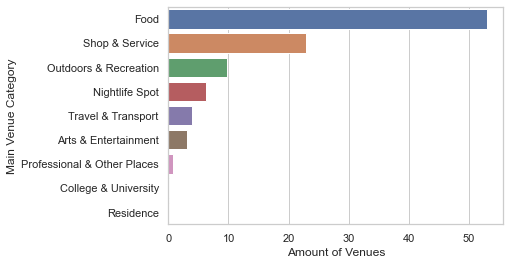

In [39]:
#get relative main venue categories
ny_venues_bor = ny_venues.groupby('Main Venue Category').count().sort_values(by=['Borough'], ascending=False)
ny_venues_bor = (ny_venues_bor / ny_venues_bor['Venue'].sum()) * 100

# plot bar plot
sns.set(style="whitegrid")
ax = sns.barplot(x='Venue', y=ny_venues_bor.index, data=ny_venues_bor)
ax.set_xlabel('Amount of Venues')
plt.show()

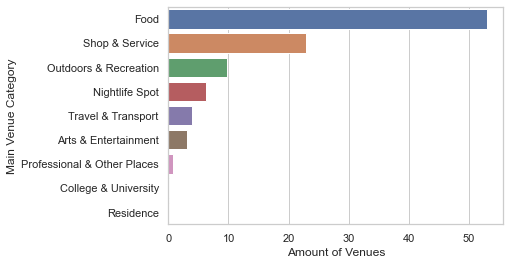

In [38]:
#get relative main venue categories
tor_venues_bor = ny_venues.groupby('Main Venue Category').count().sort_values(by=['Borough'], ascending=False)
tor_venues_bor = (tor_venues_bor / tor_venues_bor['Venue'].sum()) * 100

# plot bar plot
sns.set(style="whitegrid")
ax = sns.barplot(x='Venue', y=tor_venues_bor.index, data=tor_venues_bor)
ax.set_xlabel('Amount of Venues')
plt.show()

Unique Categories

In [58]:
ny_venues_cat = ny_venues.groupby('Venue Category').count().sort_values(by=['Borough'], ascending=False)
print('Top 5 venue categories in New York')
print(ny_venues_cat['Venue'].head())
print()
print('Total amount of unqiue venue categories: ' + str(ny_venues_cat['Venue'].sum()))

Top 5 venue categories in New York
Venue Category
Pizza Place           418
Coffee Shop           291
Italian Restaurant    276
Deli / Bodega         269
Bakery                211
Name: Venue, dtype: int64

Total amount of unqiue venue categories: 9458


In [57]:
tor_venues_cat = tor_venues.groupby('Venue Category').count().sort_values(by=['Borough'], ascending=False)
print('Top 5 venue categories in New York')
print(tor_venues_cat['Venue'].head())
print()
print('Total amount of unqiue venue categories: ' + str(tor_venues_cat['Venue'].sum()))

Top 5 venue categories in New York
Venue Category
Coffee Shop    136
Café            71
Restaurant      49
Park            48
Pizza Place     44
Name: Venue, dtype: int64

Total amount of unqiue venue categories: 1700
